Temperaturen i midten av objektet når 60 grader ved: 0.004000400040004
Temperaturen ved rander av objektet når 60 grader ved: 0.004000400040004


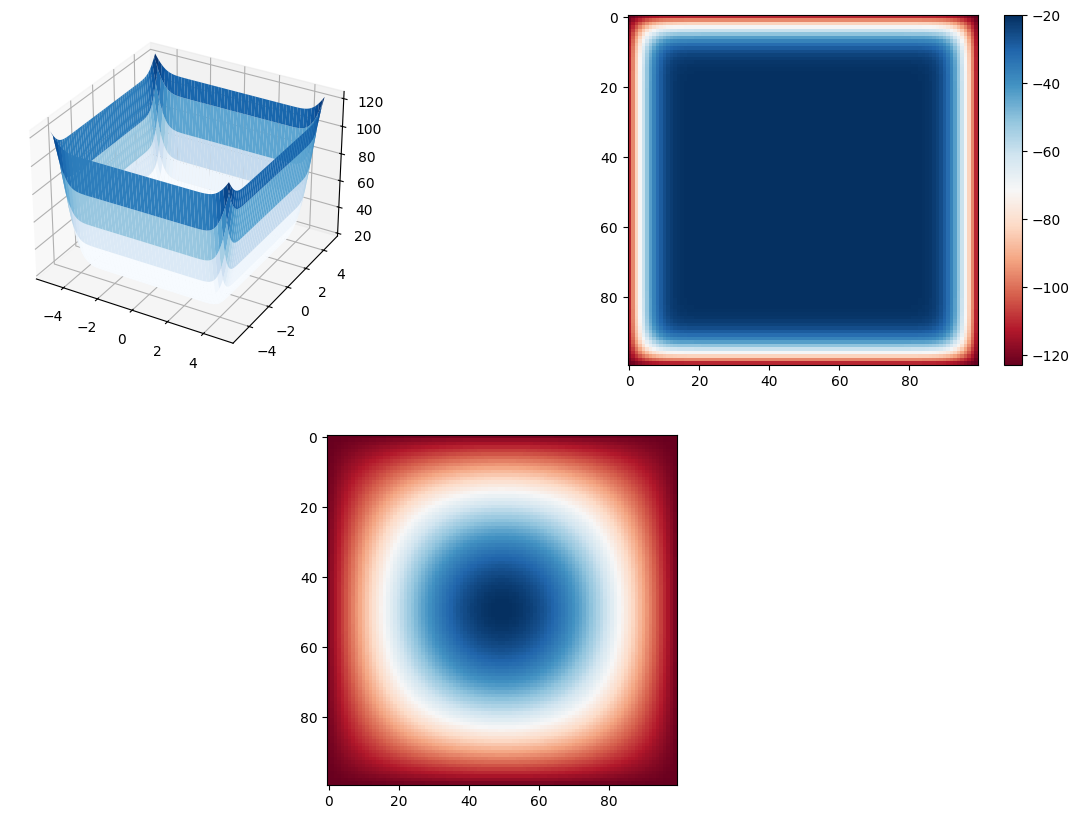

In [27]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as lin
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.cm as cm
from IPython.display import HTML


# Forlengs Euler's metode
def euler(f,x0,a,b,N):
 t = np.linspace(a,b,N)
 x = np.zeros((N,x0.size))
 x[0,:] = x0
 for i in np.arange(N-1):
   x[i+1,:] = x[i,:] + (t[i+1]-t[i])*(f(x[i],t[i]))
 return x,t

# Definerer alpha verdi for biff
K1 = 0.45
Cp = 2600
P = 1037.4
alpha = 1.6 # (K1/(Cp * P))

# Lengde verdier for X og Y
a = 5
b = 5

# Lager til X-punkter med rand og rekner steglengde
m = 100 
x=np.linspace(-a,a,m+2) 
h=x[1]-x[0]

# Lager ei matrise som representerer den andre deriverte og lager en identitets matrise
L1 = alpha*(1/h**2)*sp.diags([1,-2,1],[-1,0,1],shape=(m,m))
I1 = sp.eye(m)

# Lager til Y-punkter med rand og rekne steglengde
n=100 
y=np.linspace(-b,b,n+2) 
k = y[1]-y[0]

# Lager ei matrise som representerer den andre deriverte og lager en identitets matrise
L2 = alpha*(1/k**2)*sp.diags([1,-2,1],[-1,0,1],shape=(n,n))
I2 = sp.eye(n)

# Rekner Kroeneckerprodukt for matriser L1, I2 og I2, L2
A = sp.kron(L1,I2) + sp.kron(I1,L2)

# Randbetingelsener
Zm_l = np.zeros(m)
Zm_l[0] = -1/(h**2)

Zm_r = np.zeros(m)
Zm_r[-1] = -1/(h**2)
Zn_l = np.zeros(n)
Zn_l[0] = -1/(k**2)
Zn_r = np.zeros(n)
Zn_r[-1] = -1/(k**2)

# Funksjon for temperatur utanfor objekt
def ute(x):
 return 200

# Konvertere for å kunne rekne med matriser
ute = np.vectorize(ute)

# Rekner ut Kroeneckerprodukt for å simulere effekten temperaturen påfører objektet
F = sp.kron(ute(x[1:-1]),Zn_l) + sp.kron(ute(x[1:-1]),Zn_r) + sp.kron(Zm_l,ute(y[1:-1])) + sp.kron(Zm_r,ute(y[1:-1]))

# Differensiallikning
def f(x,t):
 return A @ x - F

# Lager 2D array uten randbetingelser
X, Y = np.meshgrid(x[1:-1],y[1:-1])

# Setter start temperatur i heile objektet til 20 grader
u0 = 20 + np.zeros(m*n)

# Rekner ut med Euler's metode
u, t = euler(f, u0, 0, 10, 10000)


# Sjekker etter kortid midtpunkt nåt 60 grader
for i_midt in range(len(t)):
    temp_middle = u[i_midt, (m * n) // 2]  # Henter temperaturen fra midten av matrisa u (temp for ojekt) ved i = tidspunkt
    if temp_middle >= 60: # Printer tidspunkt når midtpunkt når 60 grader
        print(f"Temperaturen i midten av objektet når 60 grader ved: {t[i_midt]}")
        break

# Sjekker etter kortid yterkanter av objekt når 60 grader   
for i_yttre in range(len(t)):
   XSide = u[i_yttre, :n]
   YSide = u[i_yttre, ::m]

   if np.all(XSide >= 60) and np.all(YSide >= 60):
      print(f"Temperaturen ved rander av objektet når 60 grader ved: {t[i_yttre]}")
      break


# Plotting and animation
fig = plt.figure(figsize=(15, 10))

ax2 = fig.add_subplot(2, 2, 1, projection='3d')
Z = np.reshape(u[100, :], (m, n))
ax2.plot_surface(np.transpose(X), np.transpose(Y), Z, vmin=Z.min() * 2, cmap=cm.Blues)

ax1 = fig.add_subplot(2, 2, 2)
pos = ax1.imshow(-Z, cmap='RdBu', interpolation='none')
fig.colorbar(pos, ax=ax1)

ax = fig.add_subplot(2, 1, 2)
ims = []
for i in range(40):
    im = ax.imshow(-np.reshape(u[100 * i, :], (m, n)), cmap='RdBu', animated=True)
    if i == 0:
        ax.imshow(-np.reshape(u[0, :], (m, n)), cmap='RdBu')
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_jshtml())